<a href="https://colab.research.google.com/github/LeticiaVieirg/crack_thermal_detection/blob/main/Small_Wind_Turbine_Blade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Test if python is using GPU and number of GPUs and CPUs available

In [2]:
import tensorflow as tf

# Check if TensorFlow is built with GPU support
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU!")
else:
    print("TensorFlow is not using the GPU.")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

print(tf.__version__)


TensorFlow is using the GPU!
Num GPUs Available:  1
Num CPUs Available:  1
2.10.0


2. Library Import

In [3]:


import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add, Input, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

import numpy as np
import os, sys
from scipy import ndimage
import matplotlib.pyplot as plt
import itertools
import scipy.stats

from tensorflow.keras import applications, optimizers, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels


2. Carregando o dataset

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

# Load the dataset from a Google Drive folder as ZIP file
import os
import gdown
import zipfile

# Create data directories
DATA_DIR = os.path.join(os.getcwd(), 'data')
DATASET_DIR = os.path.join(DATA_DIR, 'dataset')
os.makedirs(DATASET_DIR, exist_ok=True)

# Google Drive ZIP file ID (replace with the ZIP file ID)
#zip_file_id = '16-pPc_hHPbDLxnNE0gR88zhuKSJ6vGz4' #metal surfaces dataset
zip_file_id = '1-m_pvu89ZYzqZ3Utg_xa5sKemCFNe1B4' #small wind turbines dataset

# Output path
output_path = os.path.join(DATASET_DIR, 'dataset.zip')

# Download from Google Drive
url = f'https://drive.google.com/uc?id={zip_file_id}'
gdown.download(url, output_path, quiet=False)

# Unzip the downloaded file
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(DATASET_DIR)

print(f"Downloaded and extracted to {DATASET_DIR}")


Downloading...
From (original): https://drive.google.com/uc?id=1-m_pvu89ZYzqZ3Utg_xa5sKemCFNe1B4
From (redirected): https://drive.google.com/uc?id=1-m_pvu89ZYzqZ3Utg_xa5sKemCFNe1B4&confirm=t&uuid=e246f944-ae7b-465d-8c62-270f7841fa98
To: c:\Users\lamar\Desktop\Repository\wind turbine\wind_turb\data\dataset\dataset.zip
100%|██████████| 125M/125M [00:02<00:00, 57.8MB/s] 


Downloaded and extracted to c:\Users\lamar\Desktop\Repository\wind turbine\wind_turb\data\dataset


In [6]:
#folder='/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Train'

folder = os.path.join(DATASET_DIR) # DATASET_DIR was defined in the prior cell.

3. Estruturando o dataset

In [7]:
#image resolution
image_width = 48
image_height = 48
channels = 3 #rgb

train_files = []
i=0
for classes in ['Faulty', 'Healthy']:
    print(os.path.join(folder, classes))
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes)) if os.path.isfile(os.path.join(folder, classes, f ))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

c:\Users\lamar\Desktop\Repository\wind turbine\wind_turb\data\dataset\Faulty
c:\Users\lamar\Desktop\Repository\wind turbine\wind_turb\data\dataset\Healthy


In [8]:
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array

i = 0

valid_extensions=(".jpg", ".jpeg", ".png", ".bmp")

for classes in ['Faulty', 'Healthy']: #catregorias das imagens
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes))
     if f.lower().endswith(valid_extensions) and
             os.path.isfile(os.path.join(folder, classes, f))]

    #if os.path.isfile(os.path.join(folder, classes, f))] #seleciona as imagens e ignora pastas
    for _file in onlyfiles: #Percorre os arquivos da pasta
        img_path = os.path.join(folder, classes, _file)
        img = load_img(img_path, target_size=(image_height, image_width)) #redimenciona a iamgem
        x = img_to_array(img)

        dataset[i] = x #armazenando os dados
        mapping = {'Faulty': 0 , 'Healthy': 1} #dicionario
        y_dataset.append(mapping[classes])  #rotulo das imagens

        i += 1
        if i == 30000:
            print("%d images to array" % i)
            break

print("All images to array!")

All images to array!


6. Normalizando os dados

In [9]:
#Normalização
dataset = dataset.astype('float32')
dataset /= 255

In [10]:
classes = ['Faulty', 'Healthy']

# Dicionário para armazenar o índice da primeira imagem de cada classe
first_image_index = {}

# Encontra o índice da primeira imagem de cada classe
for i, label in enumerate(y_dataset):
    if label not in first_image_index:
        first_image_index[label] = i

# Configura a grade para exibir as imagens
num_classes = len(set(y_dataset))
num_images_per_class = 1
num_cols = num_classes
num_rows = num_images_per_class

1 2


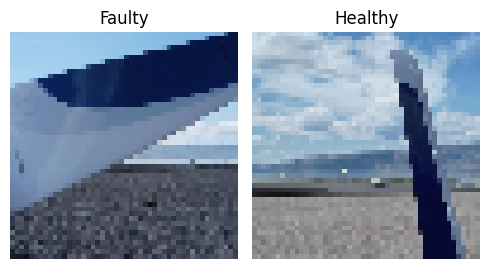

In [11]:
# Cria uma figura com uma grade de subplots

print(num_rows, num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 15))

# Loop através de cada classe
for i in range(num_classes):
    # Obtém o índice da primeira imagem da classe
    idx = first_image_index[i]

    # Obtém a imagem e converte para RGB
    pixels = dataset[idx]

    # Exibe a imagem no subplot correspondente
    axes[i].imshow(pixels, cmap='Spectral')
    axes[i].axis('off')

    # Adiciona um título para o subplot com o rótulo
    axes[i].set_title(f'{classes[i]}')

# Exibe a figura
plt.tight_layout()
plt.show()

7. Normalizando o dataset

In [12]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

2


In [13]:
# Ajusta o tamanho do dataset para coincidir com o tamanho menor entre dataset_trimmed e y_dataset_
min_length = min(len(dataset), len(y_dataset_))
dataset_trimmed = dataset[:min_length]
y_dataset_trimmed = y_dataset_[:min_length]

# Verifica se os tamanhos agora estão iguais
assert len(dataset_trimmed) == len(y_dataset_trimmed), "Os tamanhos ainda não são consistentes!"

# Dividindo em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(dataset_trimmed, y_dataset_trimmed, test_size=0.2)

print("Train set size: {}, Test set size: {}".format(len(X_train), len(X_test)))


Train set size: 3360, Test set size: 840


In [14]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 5000

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")

Tamanho do conjunto de treinamento balanceado: 10000
Tamanho do conjunto de teste: 840
Classe 0: 5000 amostras
Classe 1: 5000 amostras


In [15]:
# Criar o modelo
model = Sequential()

model.add(BatchNormalization(input_shape=(image_height, image_width, 3)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Adiciona a camada de dropout
model.add(Dense(2, activation='softmax'))  # Especifica 'softmax' como a função de ativação

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 48, 48, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 512)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0

4. Compilando o modelo

In [17]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Treinando o modelo
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Treinar o modelo
history = model.fit(balanced_X_train, balanced_y_train,validation_split= 0.2, epochs=100, callbacks=[early_stopping], batch_size=64)


Epoch 1/100
125/125 [==============================] - 12s 63ms/step - loss: 0.6585 - accuracy: 0.6066 - val_loss: 0.6516 - val_accuracy: 0.6245
Epoch 2/100
125/125 [==============================] - 7s 60ms/step - loss: 0.5409 - accuracy: 0.7042 - val_loss: 0.5660 - val_accuracy: 0.6785
Epoch 3/100
125/125 [==============================] - 7s 60ms/step - loss: 0.4695 - accuracy: 0.7590 - val_loss: 0.4680 - val_accuracy: 0.7530
Epoch 4/100
125/125 [==============================] - 7s 60ms/step - loss: 0.4173 - accuracy: 0.7881 - val_loss: 0.3962 - val_accuracy: 0.8050
Epoch 5/100
125/125 [==============================] - 7s 60ms/step - loss: 0.3771 - accuracy: 0.8146 - val_loss: 0.3253 - val_accuracy: 0.8480
Epoch 6/100
125/125 [==============================] - 7s 60ms/step - loss: 0.3397 - accuracy: 0.8375 - val_loss: 0.2853 - val_accuracy: 0.8660
Epoch 7/100
125/125 [==============================] - 7s 60ms/step - loss: 0.3161 - accuracy: 0.8511 - val_loss: 0.2844 - val_accuracy

In [19]:
val_accuracy = history.history['val_accuracy']

mean_val_accuracy = np.mean(val_accuracy)

print("Valor médio de acurácia:", mean_val_accuracy)

Valor médio de acurácia: 0.9115243830331942


5. Carregando o modelo

In [20]:
import pandas as pd
history_save = pd.DataFrame(history.history)
history_save.to_csv('datasetCAI.csv')

In [21]:
# save model structure in jason file
model_json = model.to_json()
with open("CAImodel.json", "w") as json_file:
    json_file.write(model_json)

In [22]:
model.save('modeloCAI.keras')

In [23]:
from keras.models import load_model

#modelo_carregado = load_model('/content/modeloCAI.keras')
modelo_carregado = load_model('modeloCAI.keras')

In [24]:
import pandas as pd

#history = pd.read_csv('/content/datasetCAI.csv')
history = pd.read_csv('datasetCAI.csv')

6. Plotando o modelo

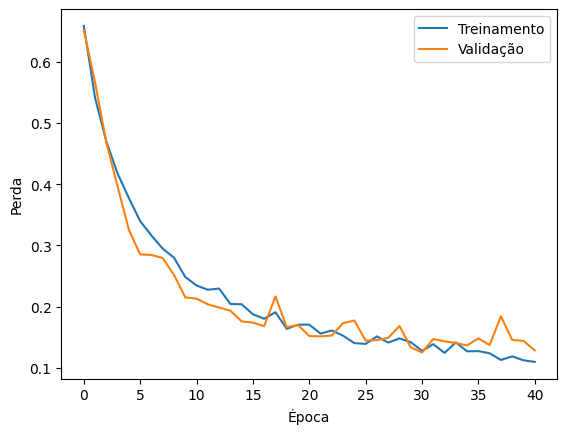

In [25]:
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])


plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc = 'upper right')
plt.show()

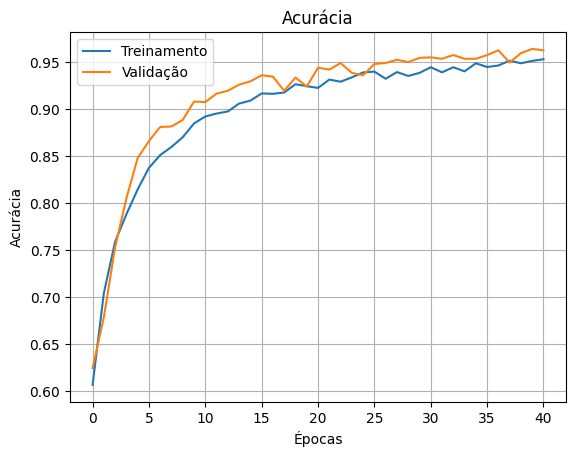

In [26]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.grid(True)
plt.show()
plt.close()

7. Salvando o modelo

In [27]:
preds = modelo_carregado.predict(X_test)


27/27 [==============================] - 1s 11ms/step


In [29]:
#Função da Matriz de Confusão

def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues
    ):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

Confusion matrix, without normalization
[[336  75]
 [104 325]]


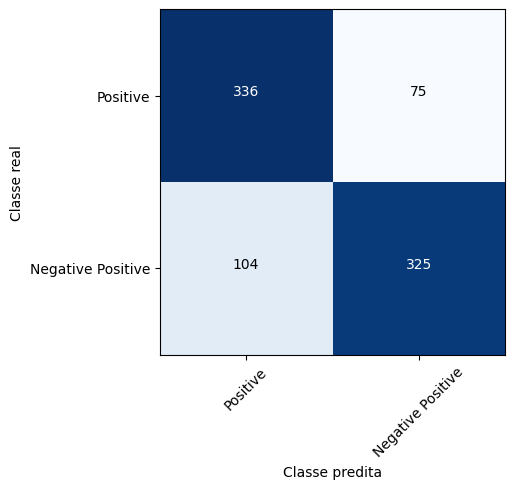

In [30]:
#Gráfico da Matriz de Confusão

y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plot_confusion_matrix(cm, classes=['Positive', 'Negative Positive'], title='Confusion matrix')
plt.show()
plt.close()

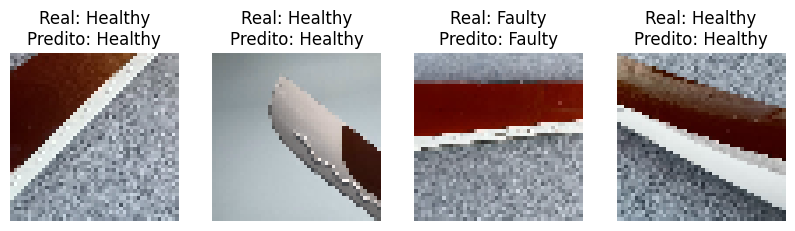

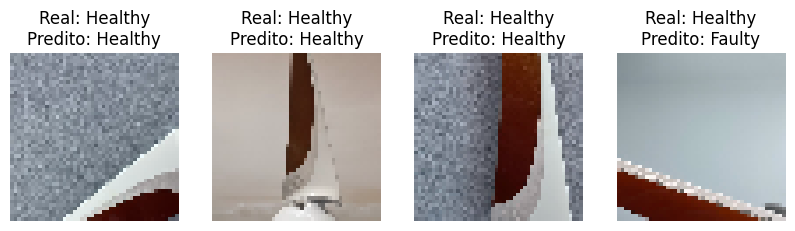

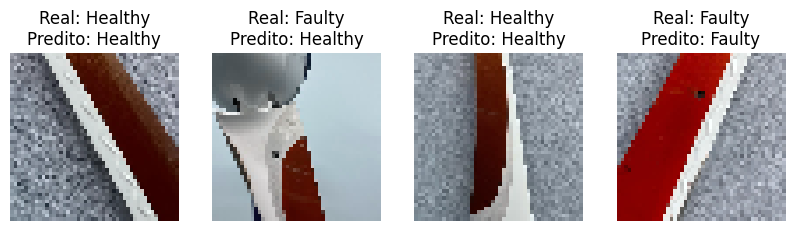

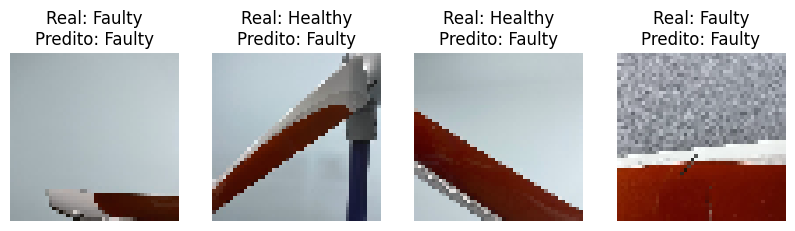

In [31]:
#Resultado das predições

n = 4
for t in range(4):
    plt.figure(figsize=(10,10))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Real: {}\nPredito: {}'.format(classes[np.argmax(y_test[i])], classes[np.argmax(preds[i])]))
        plt.axis('off')
    plt.show()

========================================================================================

Testes

Carregar o modelo salvo

In [32]:
from keras.models import load_model

modelo = load_model("modeloCAI.keras")  # Ajuste o caminho se necessário

Pre-processamento de uma imagem e classificação

In [33]:
def preprocessar_imagem(caminho_imagem):
    image_width, image_height = 48, 48  # Tamanho usado no treinamento
    img = cv2.imread(caminho_imagem)
    img = cv2.resize(img, (image_width, image_height))
    img = img.astype("float32") / 255.0  # Normalização
    img = np.expand_dims(img, axis=0)  # Adicionar batch dimension
    return img

In [35]:
#caminho_imagem = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Test/Faulty_11.jpg"

caminho_imagem = "https://drive.google.com/file/d/1fbQ9wyuw2JxG393X7ZcF44rjQl3yxBFi"


imagem = preprocessar_imagem(caminho_imagem)

predicao = modelo.predict(imagem)
classe_predita = np.argmax(predicao)  # Obtém a classe com maior probabilidade

# Mapeamento das classes
mapping = {0: "Faulty", 1: "Healthy"}
print("Classe Predita:", mapping[classe_predita])


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


Teste com a Pasta Test

In [36]:

import os
import gdown
import zipfile

# Create data directories
DATA_DIR1 = os.path.join(os.getcwd(), 'data1')
DATASET_DIR1 = os.path.join(DATA_DIR1, 'dataset1')
os.makedirs(DATASET_DIR1, exist_ok=True)

# Google Drive ZIP file ID (replace with the ZIP file ID)

zip_file_id1 = '1TjDIAi8AAb-A9yJbFyQj7Wx3UP-M8KEM' #small wind turbines dataset (test set with healthy images only)
#zip_file_id1 = '1RvaJj3_tIVRxdnVWz4dRxKwlqqHRCAWF' #small wind turbines dataset (test set with falty images only)

# Output path
output_path = os.path.join(DATASET_DIR1, 'dataset.zip')

# Download from Google Drive
url = f'https://drive.google.com/uc?id={zip_file_id1}'
gdown.download(url, output_path, quiet=False)

# Unzip the downloaded file
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(DATASET_DIR1)

print(f"Downloaded and extracted to {DATASET_DIR1}")

folder1 = os.path.join(DATASET_DIR1) # DATASET_DIR was defined in the prior cell.

valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")

# Mapeamento das classes
mapping = {0: "Faulty", 1: "Healthy"}

# Percorrer todas as imagens da pasta
for nome_arquivo in os.listdir(folder1):
    if nome_arquivo.lower().endswith(valid_extensions):  # Verifica se é uma imagem
        caminho_imagem = os.path.join(folder1, nome_arquivo)

        # Pré-processar a imagem
        imagem = preprocessar_imagem(caminho_imagem)

        # Fazer a predição
        predicao = modelo.predict(imagem)
        classe_predita = np.argmax(predicao)  # Obtém a classe com maior probabilidade

        print(f"Imagem: {nome_arquivo} -> Classe Predita: {mapping[classe_predita]}")


Downloading...
From: https://drive.google.com/uc?id=1TjDIAi8AAb-A9yJbFyQj7Wx3UP-M8KEM
To: c:\Users\lamar\Desktop\Repository\wind turbine\wind_turb\data1\dataset1\dataset.zip
100%|██████████| 18.3M/18.3M [00:00<00:00, 30.1MB/s]


Downloaded and extracted to c:\Users\lamar\Desktop\Repository\wind turbine\wind_turb\data1\dataset1


Teste com arquivos da pasta Validation

In [45]:
pasta_imagens = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Validation/Faulty"  # Substitua pelo caminho correto
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")

# Mapeamento das classes
mapping = {0: "Faulty", 1: "Healthy"}

# Percorrer todas as imagens da pasta
for nome_arquivo in os.listdir(pasta_imagens):
    if nome_arquivo.lower().endswith(valid_extensions):  # Verifica se é uma imagem
        caminho_imagem = os.path.join(pasta_imagens, nome_arquivo)

        # Pré-processar a imagem
        imagem = preprocessar_imagem(caminho_imagem)

        # Fazer a predição
        predicao = modelo.predict(imagem)
        classe_predita = np.argmax(predicao)  # Obtém a classe com maior probabilidade

        print(f"Imagem: {nome_arquivo} -> Classe Predita: {mapping[classe_predita]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Imagem: Areial_Faulty110.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Imagem: Areial_Faulty193.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Imagem: Areial_Faulty118.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Imagem: Areial_Faulty165.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Imagem: Areial_Faulty134.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Imagem: Areial_Faulty321.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Imagem: Areial_Faulty513.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Imagem: Areial_Faulty696.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Imagem: Areial_Faulty280.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Imagem: Areial_Faulty526.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Imagem: Areial_Fault

In [46]:
pasta_imagens = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Validation/Healthy"  # Substitua pelo caminho correto
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")

# Mapeamento das classes
mapping = {0: "Faulty", 1: "Healthy"}

# Percorrer todas as imagens da pasta
for nome_arquivo in os.listdir(pasta_imagens):
    if nome_arquivo.lower().endswith(valid_extensions):  # Verifica se é uma imagem
        caminho_imagem = os.path.join(pasta_imagens, nome_arquivo)

        # Pré-processar a imagem
        imagem = preprocessar_imagem(caminho_imagem)

        # Fazer a predição
        predicao = modelo.predict(imagem)
        classe_predita = np.argmax(predicao)  # Obtém a classe com maior probabilidade

        print(f"Imagem: {nome_arquivo} -> Classe Predita: {mapping[classe_predita]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Imagem: Areial_Healthy141.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Imagem: Areial_Healthy151.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Imagem: Areial_Healthy379.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Imagem: Areial_Healthy337.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Imagem: Areial_Healthy134.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Imagem: Areial_Healthy26.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Imagem: Areial_Healthy449.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Imagem: Areial_Healthy218.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Imagem: Areial_Healthy27.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Imagem: Areial_Healthy214.jpg -> Classe Predita: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Imagem: Areial

Teste do modelo - Maneira mais

In [47]:
# Função para pré-processar imagens
def preprocessar_imagem(caminho_imagem):
    image_width, image_height = 48, 48  # Tamanho usado no treinamento
    img = cv2.imread(caminho_imagem)
    img = cv2.resize(img, (image_width, image_height))
    img = img.astype("float32") / 255.0  # Normalização
    img = np.expand_dims(img, axis=0)  # Adicionar batch dimension
    return img

# Diretório com as imagens
pasta_imagens = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/dataset/CAI-SWTB-Dataset/Test/Test/Test"  # Substitua pelo caminho correto
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")

# Mapeamento das classes
mapping = {0: "Faulty", 1: "Healthy"}

# Lista para armazenar os resultados
resultados = []

# Percorrer todas as imagens da pasta
for nome_arquivo in os.listdir(pasta_imagens):
    if nome_arquivo.lower().endswith(valid_extensions):  # Verifica se é uma imagem
        caminho_imagem = os.path.join(pasta_imagens, nome_arquivo)

        # Pré-processar a imagem
        imagem = preprocessar_imagem(caminho_imagem)

        # Fazer a predição
        predicao = modelo.predict(imagem)
        classe_predita = np.argmax(predicao)  # Obtém a classe com maior probabilidade
        classe_str = mapping[classe_predita]

        # Adicionar à lista de resultados
        resultados.append([nome_arquivo, classe_str])

# Criar um DataFrame do Pandas
df = pd.DataFrame(resultados, columns=["Imagem", "Classe Predita"])

# Salvar em um arquivo CSV
caminho_csv = "resultClassification.csv"
df.to_csv(caminho_csv, index=False)

# Contar a quantidade de cada classe
contagem_classes = df["Classe Predita"].value_counts()

# Exibir os resultados
print(f"Classificação salva em: {caminho_csv}")
print("\nQuantidade de imagens por classe:")
print(contagem_classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━